# Final Project Submission
Please fill out:

* Student name: Michael Flores
* Student pace: Full time
* Scheduled project review date/time:
* Instructor name: Abhineet Kulkarni
* Blog post URL:

# Importing Libraries

In [105]:
import os, shutil
import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from keras import models, optimizers
from keras import layers
from tensorflow.keras.layers import BatchNormalization

%matplotlib inline

np.random.seed(123)

# Importing Data

All of the images we will used are contained within the chest_xray folder. The images have already been split into test, training and validation folders.

In [38]:
# Creating filepaths for all the folders
test_pne = 'chest_xray/test/PNEUMONIA'
test_norm = 'chest_xray/test/NORMAL'
train_pne = 'chest_xray/train/PNEUMONIA'
train_norm = 'chest_xray/train/NORMAL'
val_pne = 'chest_xray/val/PNEUMONIA'
val_norm = 'chest_xray/val/NORMAL'

test_dir = 'chest_xray/test/'
train_dir = 'chest_xray/train/'
val_dir = 'chest_xray/val/'

In [3]:
folders = [test_pne,test_norm, train_pne, train_norm, val_pne, val_norm]

In [4]:
for folder_name in folders: 
    print('There are', len(os.listdir(folder_name)), 'xray images in the', folder_name, 'set')

There are 390 xray images in the chest_xray/test/PNEUMONIA set
There are 234 xray images in the chest_xray/test/NORMAL set
There are 3876 xray images in the chest_xray/train/PNEUMONIA set
There are 1342 xray images in the chest_xray/train/NORMAL set
There are 9 xray images in the chest_xray/val/PNEUMONIA set
There are 9 xray images in the chest_xray/val/NORMAL set


In [5]:
pne_test_images =  [file for file in os.listdir(test_pne) if file.endswith('.jpeg')]

In [6]:
pne_test_images[0:10]

['person100_bacteria_475.jpeg',
 'person100_bacteria_477.jpeg',
 'person100_bacteria_478.jpeg',
 'person100_bacteria_479.jpeg',
 'person100_bacteria_480.jpeg',
 'person100_bacteria_481.jpeg',
 'person100_bacteria_482.jpeg',
 'person101_bacteria_483.jpeg',
 'person101_bacteria_484.jpeg',
 'person101_bacteria_485.jpeg']

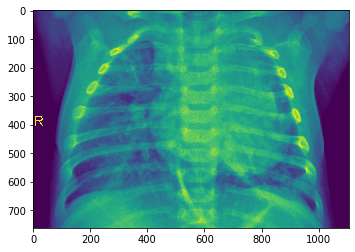

In [7]:
pne_img = mpimg.imread(test_pne +'/' + pne_test_images[0])
imgplot = plt.imshow(pne_img)
plt.show()

In [8]:
norm_test_images =  [file for file in os.listdir(test_norm) if file.endswith('.jpeg')]

In [9]:
norm_test_images[0:5]

['IM-0001-0001.jpeg',
 'IM-0003-0001.jpeg',
 'IM-0005-0001.jpeg',
 'IM-0006-0001.jpeg',
 'IM-0007-0001.jpeg']

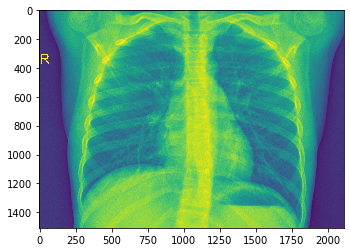

In [10]:
norm_img = mpimg.imread(test_norm +'/' + norm_test_images[1])
imgplot = plt.imshow(norm_img)
plt.show()

# Densely Connected Network (Baseline)

I will be using a densely connected network with no convolutional layers as a baseline model to test against.

In [11]:
# get all the data in the directory data/test (624 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_dir, 
        target_size=(128, 128), batch_size = 624) 

# get all the data in the directory data/validation (18 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_dir, 
        target_size=(128, 128), batch_size = 18)

# get all the data in the directory data/train (5218 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_dir, 
        target_size=(128, 128), batch_size=5218)

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [12]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [13]:
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (5216, 128, 128, 3)
train_labels shape: (5216, 2)
test_images shape: (624, 128, 128, 3)
test_labels shape: (624, 2)
val_images shape: (16, 128, 128, 3)
val_labels shape: (16, 2)


In [14]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5216, 49152)
(624, 49152)
(16, 49152)


In [15]:
train_y = np.reshape(train_labels[:,0], (5216,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

In [54]:
early_stopping_base = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='Models/best_model_baseline.h5', monitor='val_loss', save_best_only=True)]

In [55]:
# Build a baseline fully connected model

np.random.seed(123)
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(49152,))) # 2 hidden layers
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [56]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

baseline = model.fit(train_img,
                    train_y,
                    epochs=50,
                    callbacks = early_stopping_base,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/50
163/163 [==============================] - 5s 33ms/step - loss: 0.5318 - accuracy: 0.7500 - val_loss: 0.8142 - val_accuracy: 0.6250
Epoch 2/50
163/163 [==============================] - 3s 20ms/step - loss: 0.3727 - accuracy: 0.8451 - val_loss: 0.6999 - val_accuracy: 0.6875
Epoch 3/50
163/163 [==============================] - 3s 20ms/step - loss: 0.2805 - accuracy: 0.8813 - val_loss: 0.4714 - val_accuracy: 0.6875
Epoch 4/50
163/163 [==============================] - 3s 21ms/step - loss: 0.2251 - accuracy: 0.9132 - val_loss: 0.4351 - val_accuracy: 0.8125
Epoch 5/50
163/163 [==============================] - 3s 20ms/step - loss: 0.1854 - accuracy: 0.9306 - val_loss: 0.4202 - val_accuracy: 0.8125
Epoch 6/50
163/163 [==============================] - 3s 19ms/step - loss: 0.1993 - accuracy: 0.9233 - val_loss: 0.5538 - val_accuracy: 0.6875
Epoch 7/50
163/163 [==============================] - 3s 20ms/step - loss: 0.1553 - accuracy: 0.9394 - val_loss: 0.2371 - val_accuracy: 0.9375

In [18]:
# Function designed to plot accuracy and loss for both 
# test and validation sets
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['Validation Loss', 'Training Loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['Validation Accuracy', 'Training Accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

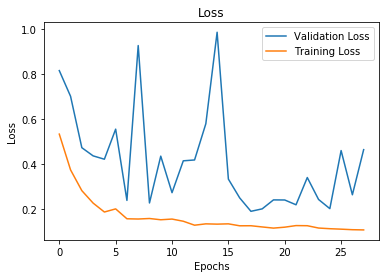

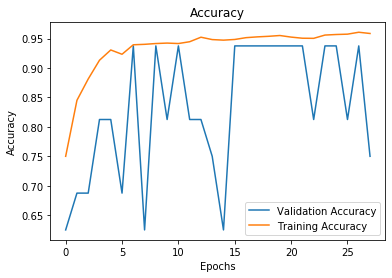

In [57]:
visualize_training_results(baseline)

In [63]:
saved_model_base = load_model('Models/best_model_baseline.h5')

In [64]:
results_train = saved_model_base.evaluate(train_images, train_y)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model_base.evaluate(test_images, test_y)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

ValueError: in user code:

    C:\Users\msf89\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1224 test_function  *
        return step_function(self, iterator)
    C:\Users\msf89\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\msf89\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\msf89\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\msf89\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\msf89\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1208 run_step  **
        outputs = model.test_step(data)
    C:\Users\msf89\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1174 test_step
        y_pred = self(x, training=False)
    C:\Users\msf89\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\msf89\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer sequential_8 is incompatible with the layer: expected axis -1 of input shape to have value 49152 but received input with shape [32, 128, 128, 3]


In [61]:
predictions_base = saved_model_base.predict_classes(test_images)
print(classification_report(test_y, predictions_base, target_names = ['Normal','Pneumonia']))

ValueError: in user code:

    C:\Users\msf89\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\msf89\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\msf89\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\msf89\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\msf89\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\msf89\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\msf89\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\msf89\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\msf89\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer sequential_8 is incompatible with the layer: expected axis -1 of input shape to have value 49152 but received input with shape [None, 128, 128, 3]


In [62]:
confusion_matrix_base = confusion_matrix(test_y, predictions_base, normalize = 'true')
print(confusion_matrix_base)

NameError: name 'predictions_base' is not defined

# Convolutional Neural Networks

## CNN Baseline

In [67]:
# Define the callbacks
early_stopping_cnn = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='Models/best_model_cnn.h5', monitor='val_loss', save_best_only=True)]

In [69]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128 ,128, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(128, activation='relu'))
cnn_model.add(layers.Dense(1, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [70]:
cnn_model = cnn_model.fit(train_images,
                    train_y,
                    epochs=50,
                    callbacks = early_stopping_cnn,
                    batch_size=64,
                    validation_data=(val_images, val_y))

Epoch 1/50
82/82 [==============================] - 55s 674ms/step - loss: 0.5751 - accuracy: 0.7406 - val_loss: 0.8344 - val_accuracy: 0.5000
Epoch 2/50
82/82 [==============================] - 55s 670ms/step - loss: 0.5340 - accuracy: 0.7448 - val_loss: 0.7562 - val_accuracy: 0.5000
Epoch 3/50
82/82 [==============================] - 53s 646ms/step - loss: 0.4852 - accuracy: 0.7673 - val_loss: 1.3654 - val_accuracy: 0.5000
Epoch 4/50
82/82 [==============================] - 55s 674ms/step - loss: 0.4160 - accuracy: 0.8190 - val_loss: 0.7021 - val_accuracy: 0.6250
Epoch 5/50
82/82 [==============================] - 53s 646ms/step - loss: 0.3105 - accuracy: 0.8704 - val_loss: 0.5616 - val_accuracy: 0.7500
Epoch 6/50
82/82 [==============================] - 54s 661ms/step - loss: 0.2323 - accuracy: 0.9051 - val_loss: 0.5121 - val_accuracy: 0.7500
Epoch 7/50
82/82 [==============================] - 55s 676ms/step - loss: 0.1999 - accuracy: 0.9218 - val_loss: 0.4694 - val_accuracy: 0.8125

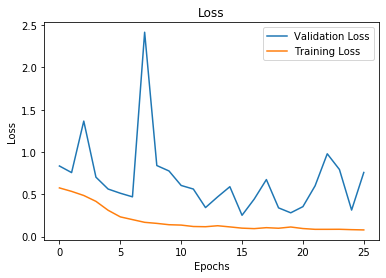

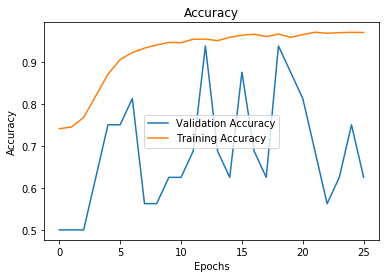

In [71]:
visualize_training_results(cnn_model)

In [72]:
saved_model_cnn = load_model('Models/best_model_cnn.h5')

In [73]:
results_train = saved_model_cnn.evaluate(train_images, train_y)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model_cnn.evaluate(test_images, test_y)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

163/163 [==============================] - 16s 97ms/step - loss: 0.1307 - accuracy: 0.9480
Training Loss: 0.131 
Training Accuracy: 0.948
----------
20/20 [==============================] - 2s 91ms/step - loss: 0.5015 - accuracy: 0.8221
Test Loss: 0.501 
Test Accuracy: 0.822


In [74]:
predictions_cnn = saved_model_cnn.predict_classes(test_images)
print(classification_report(test_y, predictions_cnn, target_names = ['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.80      0.96      0.87       390
   Pneumonia       0.89      0.60      0.72       234

    accuracy                           0.82       624
   macro avg       0.85      0.78      0.79       624
weighted avg       0.83      0.82      0.81       624



In [92]:
confusion_matrix_cnn = confusion_matrix(test_y, predictions_cnn, normalize = None)
print(confusion_matrix_cnn)

confusion_matrix_cnn = confusion_matrix(test_y, predictions_cnn, normalize = 'true')
print(confusion_matrix_cnn)

[[373  17]
 [ 94 140]]
[[0.95641026 0.04358974]
 [0.4017094  0.5982906 ]]


## CNN with Padding 

In [123]:
# Define the callbacks
early_stopping_cnn = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='Models/best_model_cnn_v2.h5', monitor='val_loss', save_best_only=True)]

In [125]:
cnn_model_v2 = models.Sequential()
cnn_model_v2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128 ,128, 3), padding = 'same'))
cnn_model_v2.add(layers.MaxPooling2D((2, 2)))

cnn_model_v2.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
cnn_model_v2.add(layers.MaxPooling2D((2, 2)))

cnn_model_v2.add(layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'))
cnn_model_v2.add(layers.MaxPooling2D((2, 2)))

cnn_model_v2.add(layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'))
cnn_model_v2.add(layers.MaxPooling2D((2, 2)))

cnn_model_v2.add(layers.Flatten())
cnn_model_v2.add(layers.Dense(512, activation='relu'))
cnn_model_v2.add(layers.Dense(1, activation='sigmoid'))

cnn_model_v2.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [126]:
cnn_model_v2 = cnn_model_v2.fit(train_images,
                    train_y,
                    epochs=50,
                    callbacks = early_stopping_cnn,
                    batch_size=64,
                    validation_data=(val_images, val_y))

Epoch 1/50
82/82 [==============================] - 74s 899ms/step - loss: 0.5811 - accuracy: 0.7377 - val_loss: 0.7926 - val_accuracy: 0.5000
Epoch 2/50
82/82 [==============================] - 73s 895ms/step - loss: 0.5417 - accuracy: 0.7429 - val_loss: 0.7559 - val_accuracy: 0.5000
Epoch 3/50
82/82 [==============================] - 77s 939ms/step - loss: 0.4791 - accuracy: 0.7720 - val_loss: 0.5799 - val_accuracy: 0.6875
Epoch 4/50
82/82 [==============================] - 79s 969ms/step - loss: 0.4243 - accuracy: 0.8102 - val_loss: 0.5066 - val_accuracy: 0.8125
Epoch 5/50
82/82 [==============================] - 66s 808ms/step - loss: 0.3369 - accuracy: 0.8597 - val_loss: 0.5789 - val_accuracy: 0.6250
Epoch 6/50
82/82 [==============================] - 71s 871ms/step - loss: 0.2708 - accuracy: 0.8930 - val_loss: 0.4057 - val_accuracy: 0.8125
Epoch 7/50
82/82 [==============================] - 79s 968ms/step - loss: 0.1978 - accuracy: 0.9218 - val_loss: 0.4422 - val_accuracy: 0.8125

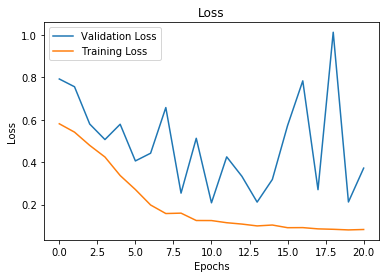

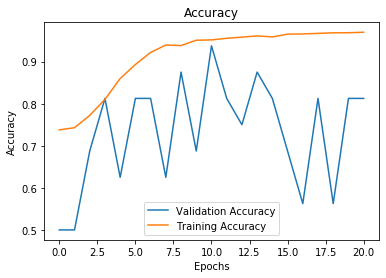

In [127]:
visualize_training_results(cnn_model_v2)

In [130]:
saved_model_cnn_v2 = load_model('Models/best_model_cnn_v2.h5')

In [131]:
results_train = saved_model_cnn_v2.evaluate(train_images, train_y)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model_cnn_v2.evaluate(test_images, test_y)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

163/163 [==============================] - 20s 124ms/step - loss: 0.1170 - accuracy: 0.9592
Training Loss: 0.117 
Training Accuracy: 0.959
----------
20/20 [==============================] - 2s 125ms/step - loss: 0.4421 - accuracy: 0.8109
Test Loss: 0.442 
Test Accuracy: 0.811


In [134]:
predictions_cnn_v2 = saved_model_cnn_v2.predict_classes(test_images)
print(classification_report(test_y, predictions_cnn_v2, target_names = ['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.79      0.96      0.86       390
   Pneumonia       0.89      0.56      0.69       234

    accuracy                           0.81       624
   macro avg       0.84      0.76      0.78       624
weighted avg       0.83      0.81      0.80       624



In [139]:
confusion_matrix_cnn = confusion_matrix(test_y, predictions_cnn_v2)
print(confusion_matrix_cnn)
confusion_matrix_cnn = confusion_matrix(test_y, predictions_cnn_v2, normalize =  'true')
print(confusion_matrix_cnn)

[[374  16]
 [102 132]]
[[0.95897436 0.04102564]
 [0.43589744 0.56410256]]


## CNN with Padding and Dropout

In [21]:
# Define the callbacks
early_stopping_cnn = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='Models/best_model_cnn_v3.h5', monitor='val_loss', save_best_only=True)]

In [27]:
cnn_model_v3 = models.Sequential()
cnn_model_v3.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128 ,128, 3), padding = 'same'))
cnn_model_v3.add(layers.MaxPooling2D((2, 2)))

cnn_model_v3.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
cnn_model_v3.add(layers.MaxPooling2D((2, 2)))

cnn_model_v3.add(layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'))
cnn_model_v3.add(layers.MaxPooling2D((2, 2)))

cnn_model_v3.add(layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'))
cnn_model_v3.add(layers.MaxPooling2D((2, 2)))

cnn_model_v3.add(layers.Flatten())
cnn_model_v3.add(layers.Dense(512, activation='relu'))
cnn_model_v3.add(layers.Dropout(0.2))
cnn_model_v3.add(layers.Dense(128, activation='relu'))
cnn_model_v3.add(layers.Dropout(0.2))
cnn_model_v3.add(layers.Dense(1, activation='sigmoid'))

cnn_model_v3.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [28]:
cnn_model_v3 = cnn_model_v3.fit(train_images,
                    train_y,
                    epochs=50,
                    callbacks = early_stopping_cnn,
                    batch_size=64,
                    validation_data=(val_images, val_y))

Epoch 1/50
82/82 [==============================] - 67s 823ms/step - loss: 0.5854 - accuracy: 0.7429 - val_loss: 0.7706 - val_accuracy: 0.5000
Epoch 2/50
82/82 [==============================] - 66s 804ms/step - loss: 0.5580 - accuracy: 0.7429 - val_loss: 0.7380 - val_accuracy: 0.5000
Epoch 3/50
82/82 [==============================] - 73s 890ms/step - loss: 0.5193 - accuracy: 0.7494 - val_loss: 1.0109 - val_accuracy: 0.5000
Epoch 4/50
82/82 [==============================] - 78s 953ms/step - loss: 0.4712 - accuracy: 0.7822 - val_loss: 0.6657 - val_accuracy: 0.5000
Epoch 5/50
82/82 [==============================] - 76s 931ms/step - loss: 0.4003 - accuracy: 0.8253 - val_loss: 0.4861 - val_accuracy: 0.8125
Epoch 6/50
82/82 [==============================] - 74s 907ms/step - loss: 0.3327 - accuracy: 0.8622 - val_loss: 0.7494 - val_accuracy: 0.6250
Epoch 7/50
82/82 [==============================] - 79s 967ms/step - loss: 0.2563 - accuracy: 0.8919 - val_loss: 0.3766 - val_accuracy: 0.8125

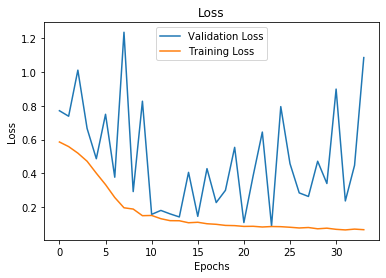

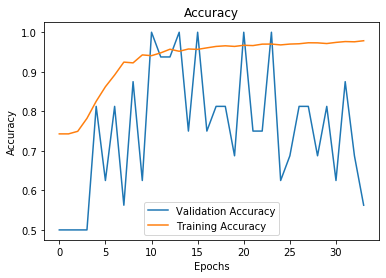

In [29]:
visualize_training_results(cnn_model_v3)

In [30]:
saved_model_cnn_v3 = load_model('Models/best_model_cnn_v3.h5')

In [31]:
results_train = saved_model_cnn_v3.evaluate(train_images, train_y)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model_cnn_v3.evaluate(test_images, test_y)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

163/163 [==============================] - 17s 103ms/step - loss: 0.1177 - accuracy: 0.9511
Training Loss: 0.118 
Training Accuracy: 0.951
----------
20/20 [==============================] - 2s 97ms/step - loss: 0.5018 - accuracy: 0.8317
Test Loss: 0.502 
Test Accuracy: 0.832


In [32]:
predictions_cnn_v3 = saved_model_cnn_v3.predict_classes(test_images)
print(classification_report(test_y, predictions_cnn_v3, target_names = ['Normal','Pneumonia']))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

      Normal       0.81      0.96      0.88       390
   Pneumonia       0.90      0.62      0.73       234

    accuracy                           0.83       624
   macro avg       0.85      0.79      0.81       624
weighted avg       0.84      0.83      0.82       624



In [33]:
confusion_matrix_cnn = confusion_matrix(test_y, predictions_cnn_v3)
print(confusion_matrix_cnn)
confusion_matrix_cnn = confusion_matrix(test_y, predictions_cnn_v3, normalize =  'true')
print(confusion_matrix_cnn)

[[374  16]
 [ 89 145]]
[[0.95897436 0.04102564]
 [0.38034188 0.61965812]]


## CNN with Data Augmentation

In [34]:
# Define the callbacks
early_stopping_cnn = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='Models/best_model_cnn_v4.h5', monitor='val_loss', save_best_only=True)]

In [42]:
train_datagen = ImageDataGenerator(rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 128x128
        target_size=(128, 128),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(val_dir, 
                                                        target_size=(128, 128), 
                                                        batch_size=32, 
                                                        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [49]:
cnn_model_v4 = models.Sequential()
cnn_model_v4.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128 ,128, 3), padding = 'same'))
cnn_model_v4.add(layers.MaxPooling2D((2, 2)))

cnn_model_v4.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
cnn_model_v4.add(layers.MaxPooling2D((2, 2)))

cnn_model_v4.add(layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'))
cnn_model_v4.add(layers.MaxPooling2D((2, 2)))

cnn_model_v4.add(layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'))
cnn_model_v4.add(layers.MaxPooling2D((2, 2)))

cnn_model_v4.add(layers.Flatten())
cnn_model_v4.add(layers.Dense(512, activation='relu'))
cnn_model_v4.add(layers.Dense(1, activation='sigmoid'))

cnn_model_v4.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [50]:
history = cnn_model_v4.fit_generator(train_generator, 
                              steps_per_epoch=100, 
                              epochs=100,
                              callbacks = early_stopping_cnn,
                              validation_data=validation_generator, 
                              validation_steps=50)

Epoch 1/100
 11/100 [==>...........................] - ETA: 1:03 - loss: nan - accuracy: 0.3239                    

KeyboardInterrupt: 

# Pre-Trained Models

## VGG19

In [103]:
# Define the callbacks
early_stopping_pretrain = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='Models/best_model_pretrain.h5', monitor='val_loss', save_best_only=True)]

In [99]:
from keras.applications import VGG19
cnn_base = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(128, 128, 3))

# Define Model Architecture
model = models.Sequential()
model.add(cnn_base)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

cnn_base.trainable = False

# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model 
print(len(model.trainable_weights))

model.summary()

vgg19 False
flatten_9 True
dense_40 True
dense_41 True
dense_42 True
dense_43 True
dense_44 True
10
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_9 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)                524352    
_________________________________________________________________
dense_41 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_42 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_43 (Dense)             (None, 128)               32896     
___________________

In [104]:
model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

# Fitting the Model
model = model.fit(train_images,
                        train_y,
                        epochs=50,
                        callbacks = early_stopping_pretrain,
                        batch_size=64,
                        validation_data=(val_images, val_y))


end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/50
82/82 [==============================] - 277s 3s/step - loss: 0.2138 - accuracy: 0.9158 - val_loss: 0.2990 - val_accuracy: 0.8750
Epoch 2/50
82/82 [==============================] - 278s 3s/step - loss: 0.1679 - accuracy: 0.9312 - val_loss: 0.2887 - val_accuracy: 0.8750
Epoch 3/50
82/82 [==============================] - 276s 3s/step - loss: 0.1524 - accuracy: 0.9375 - val_loss: 0.2507 - val_accuracy: 0.8125
Epoch 4/50
82/82 [==============================] - 275s 3s/step - loss: 0.1635 - accuracy: 0.9363 - val_loss: 0.2752 - val_accuracy: 0.8750
Epoch 5/50
82/82 [==============================] - 277s 3s/step - loss: 0.1203 - accuracy: 0.9526 - val_loss: 0.2370 - val_accuracy: 0.8125
Epoch 6/50
82/82 [==============================] - 275s 3s/step - loss: 0.1403 - accuracy: 0.9473 - val_loss: 1.2710 - val_accuracy: 0.5000
Epoch 7/50
82/82 [==============================] - 275s 3s/step - loss: 0.1097 - accuracy: 0.9582 - val_loss: 0.3187 - val_accuracy: 0.8750
Epoch 8/50
82

NameError: name 'datetime' is not defined

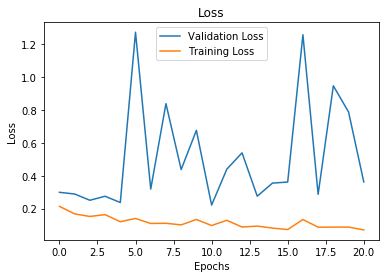

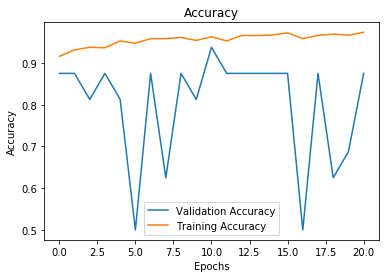

In [106]:
visualize_training_results(model)

In [107]:
saved_model_pretrain = load_model('Models/best_model_pretrain.h5')

In [108]:
results_train = saved_model_pretrain.evaluate(train_images, train_y)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model_pretrain.evaluate(test_images, test_y)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

163/163 [==============================] - 276s 2s/step - loss: 0.1178 - accuracy: 0.9563
Training Loss: 0.118 
Training Accuracy: 0.956
----------
20/20 [==============================] - 31s 2s/step - loss: 0.3953 - accuracy: 0.8606
Test Loss: 0.395 
Test Accuracy: 0.861


In [109]:
predictions_pretrain = saved_model_pretrain.predict_classes(test_images)
print(classification_report(test_y, predictions_pretrain, target_names = ['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.83      0.98      0.90       390
   Pneumonia       0.95      0.66      0.78       234

    accuracy                           0.86       624
   macro avg       0.89      0.82      0.84       624
weighted avg       0.87      0.86      0.85       624



In [110]:
confusion_matrix_cnn = confusion_matrix(test_y, predictions_pretrain)
print(confusion_matrix_cnn)
confusion_matrix_cnn = confusion_matrix(test_y, predictions_pretrain, normalize =  'true')
print(confusion_matrix_cnn)

[[382   8]
 [ 79 155]]
[[0.97948718 0.02051282]
 [0.33760684 0.66239316]]


## Xception

In [114]:
# Define the callbacks
early_stopping_pretrain = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='Models/best_model_pretrain_2.h5', monitor='val_loss', save_best_only=True)]

In [121]:
from keras.applications import Xception
cnn_base = Xception(weights='imagenet',
                 include_top=False,
                 input_shape=(128, 128, 3))

# Define Model Architecture
model = models.Sequential()
model.add(cnn_base)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

cnn_base.trainable = False

# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model 
print(len(model.trainable_weights))

model.summary()

xception False
flatten_15 True
dense_70 True
dense_71 True
dense_72 True
dense_73 True
dense_74 True
10
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten_15 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_70 (Dense)             (None, 64)                2097216   
_________________________________________________________________
dense_71 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_72 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_73 (Dense)             (None, 128)               32896     
_______________

In [122]:
model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

# Fitting the Model
model = model.fit(train_images,
                        train_y,
                        epochs=50,
                        callbacks = early_stopping_pretrain,
                        batch_size=64,
                        validation_data=(val_images, val_y))


end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/50
82/82 [==============================] - 101s 1s/step - loss: 0.3031 - accuracy: 0.8675 - val_loss: 0.7322 - val_accuracy: 0.7500
Epoch 2/50
82/82 [==============================] - 102s 1s/step - loss: 0.1852 - accuracy: 0.9254 - val_loss: 0.4134 - val_accuracy: 0.8750
Epoch 3/50
82/82 [==============================] - 100s 1s/step - loss: 0.1636 - accuracy: 0.9362 - val_loss: 0.4737 - val_accuracy: 0.8125
Epoch 4/50
82/82 [==============================] - 100s 1s/step - loss: 0.1476 - accuracy: 0.9419 - val_loss: 0.5831 - val_accuracy: 0.7500
Epoch 5/50
82/82 [==============================] - 100s 1s/step - loss: 0.1334 - accuracy: 0.9475 - val_loss: 0.4359 - val_accuracy: 0.8125
Epoch 6/50
82/82 [==============================] - 101s 1s/step - loss: 0.1162 - accuracy: 0.9569 - val_loss: 1.2077 - val_accuracy: 0.6250
Epoch 7/50
82/82 [==============================] - 100s 1s/step - loss: 0.1042 - accuracy: 0.9597 - val_loss: 0.7896 - val_accuracy: 0.6875
Epoch 8/50
82

NameError: name 'start' is not defined

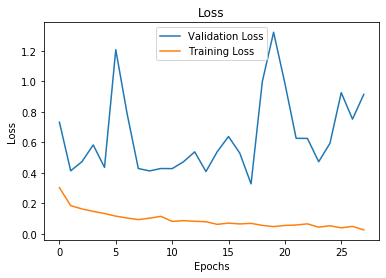

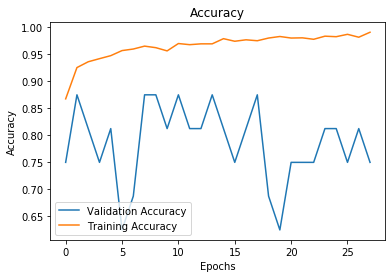

In [123]:
visualize_training_results(model)

In [124]:
saved_model_pretrain = load_model('Models/best_model_pretrain_2.h5')

In [125]:
results_train = saved_model_pretrain.evaluate(train_images, train_y)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model_pretrain.evaluate(test_images, test_y)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

163/163 [==============================] - 104s 641ms/step - loss: 0.1835 - accuracy: 0.9130
Training Loss: 0.184 
Training Accuracy: 0.913
----------
20/20 [==============================] - 12s 588ms/step - loss: 0.2930 - accuracy: 0.8846
Test Loss: 0.293 
Test Accuracy: 0.885


In [126]:
predictions_pretrain = saved_model_pretrain.predict_classes(test_images)
print(classification_report(test_y, predictions_pretrain, target_names = ['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.90      0.92      0.91       390
   Pneumonia       0.86      0.83      0.84       234

    accuracy                           0.88       624
   macro avg       0.88      0.87      0.88       624
weighted avg       0.88      0.88      0.88       624



In [127]:
confusion_matrix_cnn = confusion_matrix(test_y, predictions_pretrain)
print(confusion_matrix_cnn)
confusion_matrix_cnn = confusion_matrix(test_y, predictions_pretrain, normalize =  'true')
print(confusion_matrix_cnn)

[[358  32]
 [ 40 194]]
[[0.91794872 0.08205128]
 [0.17094017 0.82905983]]
